In [ ]:
## Tutorial by Andrej Karpathy
## Link: https://www.youtube.com/watch?v=TCH_1BHY58I

In [58]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [77]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
chars = ['.'] + chars
stoi = {n:i for i,n in enumerate(chars)}
itos = {n:i for i,n in stoi.items()}

In [93]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = '.'*block_size
        for i, ch in enumerate(w + '.'):
            curr_x = context
            req = block_size - len(context)
            temp_w = w[:i]
            temp_w = temp_w[len(temp_w)-req:]
            curr_x += temp_w
            context = context[:-1]
            X.append([stoi[x_ch] for x_ch in curr_x])
            Y.append(stoi[ch])
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(40)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [97]:
# constants
chars_len = len(chars)
n_embd = 10
n_hidden = 200

# parameters
C = torch.randn((chars_len, n_embd))
W1 = torch.randn((n_embd * block_size, n_hidden)) * (5/3) / ((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, chars_len)) * 0.01
b2 = torch.randn(chars_len) * 0
parameters = [C, W1, b1, W2, b2]

# setting require_grad to True for parameters
for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

11897

In [102]:
max_steps = 20000
batch_size = 32

losses = []

for i in range(max_steps):
    ## batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    
    ## forward
    emb = C[Xtr[ix]]
    emb_cat = emb.view(-1, n_embd * block_size)
    a_pre_activation = emb_cat @ W1 + b1
    A1 = torch.tanh(a_pre_activation)
    logits = A1 @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    ## backward
    for p in parameters:
        p.grad = None
    loss.backward()

    ## updation
    lr = 0.1 if i < 10000 else 0.01  # -> learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 1000 == 0:
        print(loss.item())
    losses.append(loss.item())

print(loss.item())

3.31072998046875
2.2399492263793945
2.094904899597168
2.088041305541992
2.267061233520508
2.4433250427246094
2.1857595443725586
2.0996737480163574
2.3101720809936523
2.1282858848571777
1.9444630146026611
2.208054304122925
2.0570390224456787
2.259486675262451
2.1074037551879883
2.2898144721984863
2.1217000484466553
2.1886017322540283
1.5514432191848755
2.238708734512329
2.1632025241851807


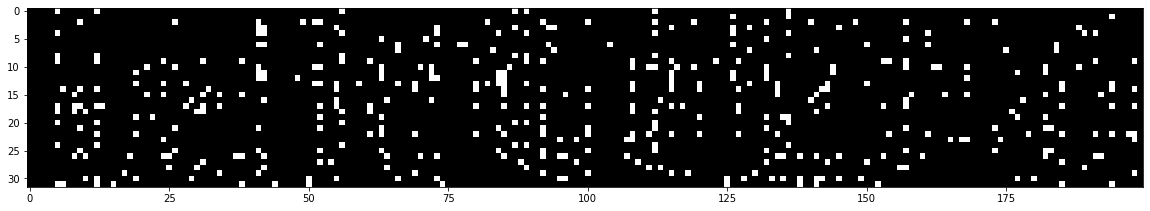

In [103]:
plt.figure(figsize=(20, 10))
plt.imshow(A1.abs() > 0.99, cmap='gray', interpolation='nearest')

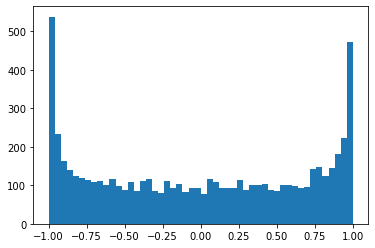

In [104]:
plt.hist(A1.view(-1).tolist(), 50);

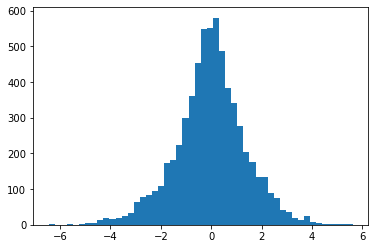

In [105]:
plt.hist(a_pre_activation.view(-1).tolist(), 50);

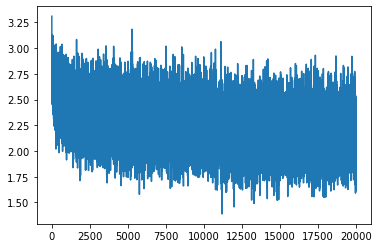

In [106]:
## Important points to be taken care of

# Loss just after initialization #
#     This should not be very high than the base normal expected loss
#             This causes the initial optimizations to concentrate on squezing the weights and rearranging them
#     Initial high logits are responsible for high loss
#             High logits means, fake confidence in incorrect answers. Which are randomly generated
#     Solution to this to minimize the logits, as all nearly to zero
#             logits = A1 @ W2 + b2
#             >> making b2 - zero at initialization
#             >> scaling down W2 by 0.1 or 0.01 or smaller values
# Taking care of activations (A1), from W1 and b1
#     Solution - same as above scaling down W1 and b1, so that it generates smaller values of A1

#### Here comes our problem, from where the magical numbers come from - that multiplied number in scaling down W1, etc.. factors
## Kaiming normal, paper: https://arxiv.org/pdf/1502.01852.pdf
## Kaiming normal, pytorch: https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_

# >>> Multiply them by (gain / sqrt(fan_in))
# --- gain change, depending upon the activation function
#     example:
#         ReLu : sqrt(2)
#         tanh : 5/3
#         leaky relu : sqrt(2 / (1 + pow(negative_slope, 2)))
#         sigmoid : 1
# --- fan_in is the count of number of input layers

plt.plot(losses)

In [107]:
@torch.no_grad()
def split_loss(split_type):
    x, y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split_type]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    A1 = torch.tanh(emb_cat @ W1 + b1)
    logits = A1 @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split_type, loss.item())

split_loss('train')
split_loss('dev')

train 2.162513256072998
dev 2.1730897426605225


In [108]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        A1 = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = A1 @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

donnacliygharrielrienaluca.
mitretlen.
vinsen.
rhya.
terr.
kha.
soppaa.
isonnie.
haan.
hia.
ber.
aviot.
motia.
cum.
gbas.
abell.
les.
khirind.
mazin.
nhi.
